# Swyft in 15 Minutes

We discuss seven key steps of a typical Swyft workflow.

## 1. Installing Swyft

We can use `pip` to install the lightning branch (latest development branch) of Swyft.

In [2]:
#!pip install https://github.com/undark-lab/swyft.git
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from scipy import stats
import pylab as plt
import torch
import swyft
from torch.nn import functional as F
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
np.random.seed(0)
import pytorch_lightning as pl
pl.__version__

'1.9.4'

## 2. Define the Simulator

Next we define a simulator class, which specifies the computational graph of our simulator.

In [4]:
class TruncatedDistribution:
    def __call__(self, *args):
        return self.sample(*args)

class Rect(TruncatedDistribution):
    def __init__(self, lo, hi):
        self._hi = hi
        self._lo = lo
        self._sample = swyft.RectBoundSampler(stats.uniform(self._lo, self._hi - self._lo))
        self._bounds = None
        
    @property
    def bounds(self):
        return self._bounds
        
    def sample(self):
        return torch.tensor(self._sample()).float()
        
    def set_bounds(self, bounds):
        self._sample = swyft.RectBoundSampler(stats.uniform(self._lo, self._hi - self._lo), bounds = bounds)
        self._bounds = bounds
        return self
    
class SwyftSimulator(swyft.Simulator):
    def __init__(self):
        super().__init__()
        self._store = None

    def get_dataloader(self, N, as_dict = True, targets = None):
        if self._store is not None:
            if self._store.sims_required > 0:
                self._store.simulate(self, batch_size = 1000)
            dm = swyft.SwyftDataModule(self._store, batch_size = 64, as_dict = as_dict, targets = targets)
        else:
            samples = self.sample(N = N)
            dm = swyft.SwyftDataModule(samples, batch_size = 64, as_dict = as_dict, targets = targets)
        return dm
    
    def set_store(self, path, N):
        shapes, dtypes = self.get_shapes_and_dtypes()
        store = swyft.ZarrStore(path)
        self._store = store.init(N, 64, shapes, dtypes)  # Only initializes once, afterwards generates a warning message
        return self
    
    def set_bounds(self, conditions):
        for k, v in conditions.items():
            self.graph[k]._fn.set_bounds(v)
        return self
    
    
class InferenceNetwork(swyft.AdamWReduceLROnPlateau, swyft.OnFitEndLoadBestModel, pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Linear(10, 2)
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = 2, num_params = 2, varnames = 'z')
        
    def forward(self, x, z):
        return self.logratios1(x, z).logratios
        
    def loss(self, x, z):
        num_pos = len(x)
        num_neg = len(x)
        z_contrastive = torch.roll(z, 1, dims=0)
        Z = torch.cat([z, z_contrastive])
        shape = [1 for _ in range(x.dim())]
        shape[0] = 2
        X = x.repeat(*shape)
        
#        print(X.shape, Z.shape)

#        num_pos = len(list(X.values())[0])  # Number of positive examples
#        num_neg = len(list(Z.values())[0]) - num_pos  # Number of negative examples

        logratios = self(X, Z)
#        print(logratios.shape)

        y = torch.zeros_like(logratios)
#        print(y.shape)
        y[:num_pos, ...] = 1
#        pos_weight = torch.ones_like(logratios[0])# * num_neg / num_pos
        loss = F.binary_cross_entropy_with_logits(
            logratios, y, reduction="none"#, pos_weight=pos_weight
        )
        num_ratios = loss.shape[1]
        loss = loss.sum() / num_neg  # Calculates batched-averaged loss
        loss = loss - 2 * np.log(2.0) * num_ratios

        return loss
        
    def training_step(self, batch, batch_idx):
        x, z = batch
        s = self.embedding(x)        
        loss = self.loss(s, z)      
        self.log("train_loss", loss, on_step=True, on_epoch=False)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, z = batch
        s = self.embedding(x)   
        loss = self.loss(s, z)      
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def set_observation(self, x0):
        self._x0 = x0
    
    def predict_step(self, batch, batch_idx):
        z = batch[0]
        x = self._x0.unsqueeze(0)
#        print(x.shape, z.shape)
        s = self.embedding(x)
#        print(s.shape, z.shape)
        s, z = swyft.equalize_tensors(s, z)
#        print(s.shape, z.shape)
        logratios = self(s, z)
        return logratios, z
    
class InferenceTask:
    def __init__(self, name, network, data_name, param_name, simulator = None, trainer = None):
        self._name = name
        self._network = network
        self._targets = [data_name, param_name]
        self._sim = simulator
        self._trainer = trainer
    
    def execute(self):
        dm = self._sim.get_dataloader(10000, as_dict = False, targets = self._targets)
        self._trainer.fit(self._network, dm)
    
    def get_posteriors(self, x0, loglike_external = None):
        self._network.set_observation(x0)
        prior_samples = self._sim.get_dataloader(10000, as_dict = False, targets = [self._targets[1]])
        predictions = self._trainer.predict(self._network, prior_samples)
        logratios = torch.cat([p[0] for p in predictions])
        params = torch.cat([p[1] for p in predictions])
        
        if loglike_external is not None:
            logratios += loglike_external(params)
            
        results = swyft.LogRatioSamples(logratios, params.unsqueeze(-1), np.array([['z[0]'], ['z[1]']]), None)
        return results
    
    def get_bounds(self, x0):
        results = self.get_posteriors(x0)
        bounds = swyft.collect_rect_bounds(results, 'z', (2,), threshold = 1e-6)
        sampler = self._sim.graph[self._targets[1]]
        return bounds

In [6]:
class Simulator(SwyftSimulator):
    def __init__(self):
        super().__init__()
        self.x = torch.linspace(-1, 1, 10)
         
    def build(self, graph):
        z = graph.node('z', Rect(np.array([-1, -1]), np.array([1, 1])))
        f = graph.node('f', lambda z: z[0] + z[1]*self.x, z)
        x = graph.node('x', lambda f: f + torch.randn(10)*0.1, f)

sim = Simulator()
#sim.set_store("./test3", 10000)

z0 = np.array([0.3, 0.7])
x0 = sim.sample(conditions = {"z": z0})['x']
x0 = torch.tensor(x0)

/var/folders/xy/7m07k3417w76kc7zq5jpq3500000gn/T/ipykernel_10546/2921352143.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0)


In [12]:
class Workspace:
    def __init__(self, inference_strategy, simulator):
        self._inference_strategy = inference_strategy
        self._simulator = simulator
        
    def execute(self):
        self.simulate()
        self.train()
        self.sample()
        self.bound()
    
    def simulate(self):
        pass
    
    def train(self):
        pass
    
    def sample(self):
        pass
        # Treating theta task:
        # - Find theta as task target
        # - Check for prior dependencies or other likelihood-like contributions in simulator
        # - Sample, assuming that task target knows how to incorporate external likelihoods
        # - Should result be represented as single total log likelihood, or individual loglikes that are combined at the end?
        # - Maybe loglike and partial_loglike?
        #
        # Treating delta task: 
        # - Use theta prior samples as starting point
        # - Generate theta conditioned samples for delta posteriors
        # - This step could include extra noise?
    
    def bound(self):
        pass

class InferenceStrategy:
    def __init__(self):
        super().__init__()
    
    def build(self, graph):
        t1 = graph.node("t1", InferenceNetwork(), "x", "delta")
        t2 = graph.node("t2", InferenceNetwork(), "x", "theta")
#        t3 = graph.node("t3", InferenceNetwork(), ("x", "delta"), "theta")  # vs reparametrization ?????????

infs = InferenceStrategy()
        
ws = Workspace(infs, sim)
ws.execute()

## 4. Train the model

In [9]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, max_epochs = 10)
inftask = InferenceTask("T1", InferenceNetwork(), "x", "z", simulator = sim, trainer = trainer)
inftask.execute()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cweniger/opt/anaconda3/envs/native3/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | embedding  | Linear                 | 22    
1 | logratios1 | LogRatioEstimator_1dim | 34.9 K
------------------------------------------------------
35.0 K    Trainable params
0         Non-trainable params
35.0 K    Total params
0.140     Total estimated model params size (MB)


SwyftDataModule setup stage: TrainerFn.FITTING


Sanity Checking: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reloading best model: /Users/cweniger/Documents/swyft/notebooks/dev/lightning_logs/version_104/checkpoints/epoch=8-step=1125.ckpt


  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


SwyftDataModule setup stage: TrainerFn.PREDICTING


/Users/cweniger/opt/anaconda3/envs/native3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 125it [00:00, ?it/s]

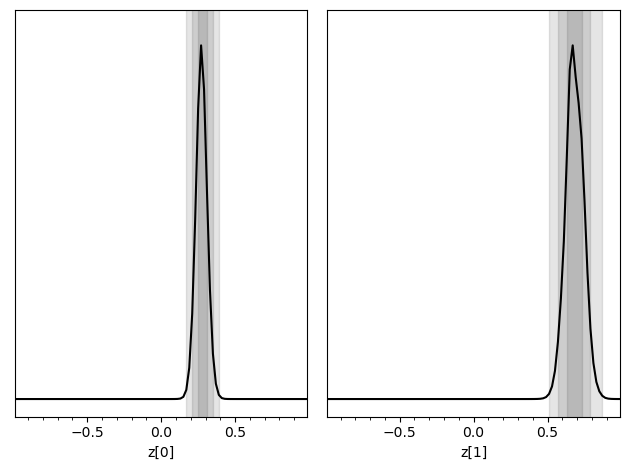

In [10]:
results = inftask.get_posteriors(x0)
swyft.plot_posterior(results, ['z[0]', 'z[1]']);

In [11]:
bounds = inftask.get_bounds(x0)
sim = Simulator().set_bounds({"z": bounds})
bounds

  0%|          | 0/10000 [00:00<?, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


SwyftDataModule setup stage: TrainerFn.PREDICTING


Predicting: 125it [00:00, ?it/s]

tensor([[-0.7713,  0.9997],
        [-0.3570,  0.9999]])